In [1]:
import numpy as np
import time
import copy
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal

import gym
import pybullet
import pybulletgym.envs

from collections import deque
from operator import itemgetter
from statistics import mean
from tqdm import tqdm

import matplotlib.pyplot as plt

def weighSync(target_model, source_model, tau=0.001):
    ''' A function to soft update target networks '''
    assert isinstance(tau, float) and tau>0

    for param_target, param_source in zip(target_model.parameters(), source_model.parameters()):
        # Wrap in torch.no_grad() because weights have requires_grad=True, 
        # but we don't need to track this in autograd
        with torch.no_grad():
            param_target = tau*param_source + (1-tau)*param_target
    
    return target_model, source_model


class Replay():
    def __init__(self, buffer_size, init_length, state_dim, action_dim, env):
        """
        A function to initialize the replay buffer.

        param: init_length : Initial number of transitions to collect
        param: state_dim : Size of the state space
        param: action_dim : Size of the action space
        param: env : gym environment object
        """
        assert isinstance(buffer_size, int) and buffer_size>0
        assert isinstance(init_length, int) and init_length>0
        assert isinstance(state_dim, int) and state_dim>0
        assert isinstance(action_dim, int) and action_dim>0
        
        self.buffer_size = buffer_size
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.buffer = deque() #list like object for which removing elements from left is faster
        
        s = env.reset()
        for i in range(init_length):
            a = env.action_space.sample()
            s_prime, r, done, _ = env.step(a)
            self.buffer.append((s,a,r,s_prime))
#             self.buffer.append({
#                 's': s,
#                 'a': a,
#                 'r': r,
#                 's_prime': s_prime
#             })
    
    def __len__(self):
        ''' Return number of elements in buffer'''
        return len(self.buffer)

    def buffer_add(self, exp):
        """
        A function to add a dictionary to the buffer
        param: exp : A tuple consisting of (state, action, reward, next state) in that order
        """
#         assert isinstance(exp, dict) and len(exp) == 4
        assert isinstance(exp, tuple) and len(exp) == 4
        assert len(self.buffer) <= self.buffer_size, 'Buffer size exceeded. You fucked up'
        
        if len(self) < self.buffer_size:
            self.buffer.append(exp)
        else:
            self.buffer.popleft() #removing the 1st element (left most element)
            self.buffer.append(exp)

    def buffer_sample(self, N):
        """
        A function to sample N points from the buffer
        param: N : Number of samples to obtain from the buffer
        """
        assert isinstance(N, int) and N>0
        indices = list(np.random.randint(low=0, high=len(self), size=N, dtype='int'))
        sample = itemgetter(*indices)(self.buffer) #extarct values at indices from buffer
        
        assert len(sample) == N, 'You fucked up sampling bruh'
        return sample


class Actor(nn.Module):
    #TODO: Complete the function
    def __init__(self, state_dim, action_dim):
        """
        Initialize the network
        param: state_dim : Size of the state space
        param: action_dim: Size of the action space
        """
        assert isinstance(state_dim, int) and state_dim>0
        assert isinstance(action_dim, int) and action_dim>0
        
        super(Actor, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # NN layers and activations
        self.fc1 = nn.Linear(state_dim, 400)
        self.hidden1 = nn.Linear(400, 300)
        self.fc2 = nn.Linear(300, action_dim)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, state):
        """
        Define the forward pass
        param: state: The state of the environment
        """
#         assert state.shape[1] == self.state_dim, 'state must be of dim (batch_size, %d)'%self.state_dim
        
        if not(isinstance(state, torch.Tensor)):
            state = torch.from_numpy(state).float()
        
        x = state
        x = self.relu(self.fc1(x))
        x = self.relu(self.hidden1(x))
        x = self.tanh(self.fc2(x))

        return x
    
    def getAction(self, state, add_noise_flag = False, noise = 0.1):
        '''
        Returns an action by doing a forward pass. If add_noise_flag is True, 
        action is sampled from a multivariate Normal distributio with stddev = noise and mean = output of net
        
        :rtype: np.ndarray
        '''
        assert isinstance(state, np.ndarray)
#         assert state.shape[1] == self.state_dim, 'state must be of dim (batch_size, %d)'%self.state_dim
        assert isinstance(noise, (int, float)) and noise >=0
        assert isinstance(add_noise_flag, bool)
        
        state = torch.from_numpy(state).float()
        action = self.forward(state) #forward pass
        
        if add_noise_flag:
            # Sampling from the nD Gaussian
            m = MultivariateNormal(action, torch.eye(self.action_dim)*noise)
            action = m.sample()
        
        return action.detach().squeeze().numpy()


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        """
        Initialize the critic
        param: state_dim : Size of the state space
        param: action_dim : Size of the action space
        """
        assert isinstance(state_dim, int) and state_dim>0
        assert isinstance(action_dim, int) and action_dim>0
        
        super(Critic, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # NN layers and activations
        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.hidden1 = nn.Linear(400, 300)
        self.fc2 = nn.Linear(300, 1)
        self.relu = nn.ReLU()

    def forward(self, state, action):
        """ Define the forward pass of the critic """
        assert isinstance(state, np.ndarray)
        assert isinstance(action, np.ndarray)
        assert state.shape[1] == self.state_dim, 'state must be of dim (batch_size, %d)'%self.state_dim
        assert action.shape[1] == self.action_dim, 'action must be of dim (batch_size, %d)'%self.action_dim
        
        state, action = torch.from_numpy(state).float(), torch.from_numpy(action).float() #numpy to torch tensor
        try:
            x = torch.cat((state, action), dim=0) #concatenating to form input
        except RuntimeError:
            x = torch.cat((state, action), dim=1) #concatenating to form input
        x = self.relu(self.fc1(x))
        x = self.relu(self.hidden1(x))
        x = self.fc2(x)
        
        return x


class DDPG():
    def __init__(
            self,
            env,
            test_env,
            state_dim,    
            action_dim,
            critic_lr=3e-4,
            actor_lr=3e-4,
            gamma=0.99,
            batch_size=100,
            ev_n_steps=100,
            verbose=False
    ):
        """
        Implementing DPPG algorithm from paper - Continuous control with deep reinforcement learning
        link - https://arxiv.org/pdf/1509.02971.pdf
        
        param: env: An gym environment
        param: action_dim: Size of action space
        param: state_dim: Size of state space
        param: critic_lr: Learning rate of the critic
        param: actor_lr: Learning rate of the actor
        param: gamma: The discount factor
        param: batch_size: The batch size for training
        """

        assert isinstance(state_dim, int) and state_dim>0
        assert isinstance(action_dim, int) and action_dim>0
        assert isinstance(batch_size, int) and batch_size>0
        assert isinstance(critic_lr, (int, float)) and critic_lr>0
        assert isinstance(actor_lr, (int, float)) and actor_lr>0
        assert isinstance(gamma, (int, float)) and gamma>0
        assert isinstance(ev_n_steps, (int, float)) and ev_n_steps>0

        self.gamma = gamma
        self.batch_size = batch_size
        self.ev_n_steps = ev_n_steps
        self.env = env
        self.test_env = test_env
        self.num_episodes = 0
        self.avg_rewards = []
        self.obj_actor = []
        self.loss_critic = []

        # Create a actor and actor_target with same initial weights
        self.actor = Actor(state_dim, action_dim)
        self.actor = self.init_weights(self.actor) #initialize weights according to paper
        self.actor_target = copy.deepcopy(self.actor) #both networks have the same initial weights 

        # Create a critic and critic_target with same initial weights
        self.critic = Critic(state_dim, action_dim)
        self.critic = self.init_weights(self.critic) #initialize weights according to paper
        self.critic_target = copy.deepcopy(self.critic) #both networks have the same initial weights 

        # Define optimizer for actor and critic
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.loss_fn = nn.MSELoss(reduction='mean')

        # Define a replay buffer
        self.ReplayBuffer = Replay(10000, 1000, state_dim, action_dim, self.env)
    
    def init_weights(self, network):
        '''
        Initialize weights (as mentioned in paper) from a uniform distribution 
        based on the fan-in of the layer
        
        WARNING: Will only work if each layer is fully connected
        '''
        
        for name, param in network.named_parameters():
            if 'bias' in name: #if bias param, use f of the same layer
                f = last_f
            else:
                f = param.shape[1] #picking 2nd dim = number of inputs for that layer
                last_f = f
            # Initialize weights by sampling from uniform dist.
            assert isinstance(f, int) and f>0, 'fan in must be int and greater than 0'
            nn.init.uniform_(param.data, a = -1/np.sqrt(f), b = 1/np.sqrt(f))
        
        return network
    
    def save_actor(self, index):
        ''' Saves the policy NN'''
        filename = 'q1_policy_' + str(index) + '.pth.tar'
        state = { 'state_dict': self.actor.state_dict(),
                 'optimizer': self.optimizer_actor.state_dict() }
        torch.save(state, filename)
        torch.save(self.best_actor_state, 'best'+filename)
        
    def save_critic(self, index):
        ''' Saves the critic NN'''
        filename = 'q1_critic_' + str(index) + '.pth.tar'
        state = { 'state_dict': self.critic.state_dict(),
                 'optimizer': self.optimizer_critic.state_dict() }
        torch.save(state, filename)
    
    def update_target_networks(self):
        """
        A function to update the target networks
        """
        weighSync(self.actor_target, self.actor)
        weighSync(self.critic_target, self.critic)
    
    def getAverageReward(self):
        ''' Run the policy and return average reward '''
        rewards = []
        s = self.test_env.reset()
        done = False
        while not(done):
            a = self.actor(s).detach().squeeze().numpy()
            s, r, done, _ = self.test_env.step(a)
            rewards.append(r)
        
        avg_reward = sum(rewards)
        assert isinstance(avg_reward, (int, float))
        
        return avg_reward

    def train(self, max_num_steps):
        """
        Train the policy for the given number of iterations
        :param num_steps:The number of steps to train the policy for
        """
        assert isinstance(max_num_steps, int) and max_num_steps>0
        
        gamma = self.gamma
        state = self.env.reset()
        done = False
        best_r = -np.inf
        # Training starts now
        for num_steps in tqdm(range(max_num_steps)):
            # Reset env when it reached terminal state
            if done:
                self.num_episodes += 1
                state = self.env.reset()
            
            action = self.actor.getAction(state, add_noise_flag = True, noise = 0.1)
            state_next, rewd, done, _ = self.env.step(action)
            
            # Storing transition in buffer
            self.ReplayBuffer.buffer_add((state,action,rewd,state_next))
            state = state_next
#             self.ReplayBuffer.buffer_add({
#                 's': s,
#                 'a': a,
#                 'r': r,
#                 's_prime': s_prime
#             })
            # Sampling N points from buffer
            minibatch = self.ReplayBuffer.buffer_sample(N = self.batch_size)

            
            # Operating on minibatch
            s = np.array([el[0] for el in minibatch])                        #dim (batch_size, state_dim)
            a = np.array([el[1] for el in minibatch])                        #dim (batch_size, action_dim)
            r = torch.Tensor([el[2] for el in minibatch]).unsqueeze(dim=1)   #dim (batch_size, 1)
            s_prime = np.array([el[3] for el in minibatch])                  #dim (batch_size, state_dim)
            
            a_target = self.actor_target.getAction(s_prime, add_noise_flag=False) #dim(batch_size, action_dim)
            y_i = r + gamma*self.critic_target(s_prime, a_target)            #dim (batch_size, 1)
            loss_critic = self.loss_fn(self.critic(s,a), y_i) #mse loss      #dim (batch_size, 1)
            
            a = self.actor.getAction(s_prime, add_noise_flag=False)
            obj_actor = self.critic(s, a).mean()
#             print(type(a_target), a_target.shape)
#             print(type(y_i), y_i.shape)
#             print(type(loss_critic), loss_critic)
#             print(type(a), a.shape)
#             print(type(obj), obj)
            
#             loss_critic = torch.tensor([0]).float()
#             obj_actor = torch.tensor([0]).float()
#             for sample in minibatch:
#                 s, a, r, s_prime = sample['s'], sample['a'], sample['r'], sample['s_prime']
#                 # Calculating critic loss
#                 a_target = self.actor_target.getAction(s_prime, add_noise_flag=False)
#                 y_i = r + gamma*self.critic_target(s_prime, a_target)
#                 loss_critic = self.loss_fn(self.critic(s,a), y_i) #mse loss
                
#                 # Calculating actor loss
#                 a = self.actor.getAction(s_prime, add_noise_flag=False)
#                 obj_actor += self.critic(s, a)
            
            # Zero gradients of optimizer
            self.optimizer_critic.zero_grad()    
            self.optimizer_actor.zero_grad()
            # Update critic
            loss_critic.backward()
            self.optimizer_critic.step()
            # Update actor
            obj_actor *= -1 #multiplying with negative so it does gradient ascent
            obj_actor.backward()
            self.optimizer_actor.step()
            # Update target networks
            self.update_target_networks()
            
            # Store losses
            self.obj_actor.append(obj_actor.item())
            self.loss_critic.append(loss_critic.item())
            
            if num_steps%self.ev_n_steps == 0:
                r = self.getAverageReward()
                # Saving best actor model till now
                is_best = r > best_r
                best_r = max(r, best_r)
                if is_best:
                    self.best_actor_state = {'state_dict': self.actor.state_dict(),
                                             'optimizer': self.optimizer_actor.state_dict() }
                
                self.avg_rewards.append(r)
                if verbose:
                    print('Num steps: {0} \t Avg Reward: {1:.3f} \t Obj(Actor): {2:.3f} \t Loss(Critic): {3:.3f}'
                          .format(num_steps, r, obj_actor.item(), loss_critic.item()))
                
                
            

In [3]:
if __name__ == "__main__":
    
    # Seed values
    torch.manual_seed(4)
    
    # Define the environment
    env = gym.make("modified_gym_env:ReacherPyBulletEnv-v1", rand_init=True)
    test_env = copy.deepcopy(env)
    plot = True
    verbose = True
    
    # Define Deep Deterministic Policy Gradient object
    ddpg_object = DDPG(
        env,
        test_env,
        8,
        2,
        critic_lr=1e-3,
        actor_lr=1e-4,
        gamma=0.99,
        batch_size=500,
        ev_n_steps=1000, #evaluate every n steps
        verbose=verbose
    )
    # Train the policy
    ddpg_object.train(int(5e3))

options= 


  0%|          | 7/5000 [00:00<07:45, 10.72it/s]

options= 
Num steps: 0 	 Avg Reward: -19.398 	 Obj(Actor): 0.076 	 Loss(Critic): 1.834


 20%|██        | 1008/5000 [00:20<01:32, 43.20it/s]

Num steps: 1000 	 Avg Reward: -19.842 	 Obj(Actor): -0.303 	 Loss(Critic): 0.468


 40%|████      | 2010/5000 [00:42<01:10, 42.45it/s]

Num steps: 2000 	 Avg Reward: -22.384 	 Obj(Actor): -0.183 	 Loss(Critic): 0.382


 60%|██████    | 3010/5000 [01:02<00:45, 43.38it/s]

Num steps: 3000 	 Avg Reward: -22.918 	 Obj(Actor): -0.056 	 Loss(Critic): 0.233


 80%|████████  | 4006/5000 [01:23<00:21, 45.95it/s]

Num steps: 4000 	 Avg Reward: -3.541 	 Obj(Actor): -0.015 	 Loss(Critic): 0.225


100%|██████████| 5000/5000 [01:44<00:00, 47.87it/s]


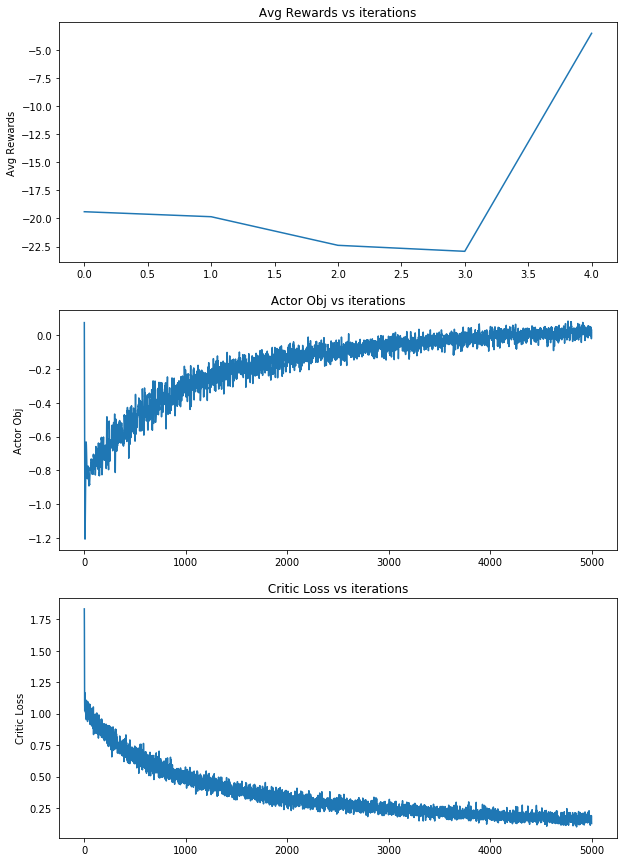

In [4]:
if plot:
    fig, axs = plt.subplots(3,1, figsize=(10,15))
    axs = axs.flatten()
    axs[0].plot(ddpg_object.avg_rewards)
    axs[0].set_ylabel('Avg Rewards')
    axs[0].set_title(' Avg Rewards vs iterations ')
#     axs[1].plot(ddpg_object.obj_actor[::ddpg_object.ev_n_steps])
    axs[1].plot(ddpg_object.obj_actor)
    axs[1].set_ylabel('Actor Obj')
    axs[1].set_title(' Actor Obj vs iterations ')
#     axs[2].plot(ddpg_object.loss_critic[::ddpg_object.ev_n_steps])
    axs[2].plot(ddpg_object.loss_critic)
    axs[2].set_ylabel('Critic Loss')
    axs[2].set_title(' Critic Loss vs iterations ')
    plt.savefig(fname, dpi=None

In [5]:
# ddpg_object.save_actor(6)